In [ ]:
# Setting the parameters
storage_account_name = "energyoptstor"  # storage account name
container_name = "raw-data"             # container name
storage_account_key = "MASKED"  # storage account key

# Define the URI for the Blob Storage
blob_url = f"wasbs://{container_name}@{storage_account_name}.blob.core.windows.net/"

# Mount the storage to Databricks
dbutils.fs.mount(
  source = blob_url,
  mount_point = "/mnt/rawdata",  # Mount point
  extra_configs = {
    f"fs.azure.account.key.{storage_account_name}.blob.core.windows.net": storage_account_key
  }
)

# Mount verification
display(dbutils.fs.ls("/mnt/rawdata"))


path,name,size,modificationTime
dbfs:/mnt/rawdata/ikea_energy_consumption.csv,ikea_energy_consumption.csv,5704,1733141570000


In [ ]:
# Loading the dataset into a Spark DataFrame
file_path = "/mnt/rawdata/ikea_energy_consumption.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

# DataFrame verification
df.show(5)


+----------+----------+----------------------+
|      Date|Department|EnergyConsumption(kWh)|
+----------+----------+----------------------+
|2024-11-01|  Lighting|     337.7420593060477|
|2024-11-01|      HVAC|     61.25483985020012|
|2024-11-01|Appliances|    173.76319326610366|
|2024-11-01|    Office|    150.44483216697023|
|2024-11-01| Warehouse|     381.4120463738056|
+----------+----------+----------------------+
only showing top 5 rows



In [ ]:
%python
from pyspark.sql.functions import col, sum as _sum

# Check for missing values
missing_values = df.select(
    [_sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]
)
display(missing_values)

Date,Department,EnergyConsumption(kWh)
0,0,0


In [ ]:
# Remove duplicates (if any)
df = df.dropDuplicates()

# Clean column names (e.g., remove spaces or special characters)
df = df.select([col(c).alias(c.replace(" ", "_").replace("-", "_")) for c in df.columns])


In [ ]:
%python
# Group by date and sum energy consumption
df_grouped = df.groupBy("date").agg({"EnergyConsumption(kWh)": "sum"})
display(df_grouped)

date,sum(EnergyConsumption(kWh))
2024-11-02,1198.3916170962311
2024-11-25,1425.1488447168053
2024-11-23,1478.9985208245407
2024-11-29,1413.5711118189454
2024-11-27,1274.2233048100431
2024-11-05,1580.6057809109154
2024-11-15,1600.1695287193336
2024-11-14,979.1539681521274
2024-11-06,1139.7747233682653
2024-11-07,1791.1322316747805


In [ ]:
# Summary statistics
df.describe().show()


+-------+----------+----------------------+
|summary|Department|EnergyConsumption(kWh)|
+-------+----------+----------------------+
|  count|       150|                   150|
|   mean|      NULL|     268.1915956680413|
| stddev|      NULL|    132.68977504420113|
|    min|Appliances|     50.25735325757458|
|    max| Warehouse|     498.8919229227996|
+-------+----------+----------------------+



In [ ]:
%python
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.sql.functions import col

# Rename 'EnergyConsumption(kWh)' to 'energy_consumption' 
df = df.withColumnRenamed("EnergyConsumption(kWh)", "energy_consumption")

# Converting 'Date' to a numeric type 
df = df.withColumn("Date", col("Date").cast("timestamp").cast("long"))

# Converting 'Department' to a numeric type using StringIndexer
indexer = StringIndexer(inputCol="Department", outputCol="DepartmentIndex")
df = indexer.fit(df).transform(df)

# Creating a feature vector
assembler = VectorAssembler(inputCols=["Date", "DepartmentIndex"], outputCol="feature")
df = assembler.transform(df)

# Initializing and fitting the linear regression model
lr = LinearRegression(featuresCol="feature", labelCol="energy_consumption")
lr_model = lr.fit(df)
lr_predictions = lr_model.transform(df)

display(lr_predictions)

Date,Department,energy_consumption,DepartmentIndex,feature,prediction
1730592000,Office,139.47694280899182,3.0,"Map(vectorType -> dense, length -> 2, values -> List(1.730592E9, 3.0))",254.3503576659714
1731715200,Appliances,256.48333366432945,0.0,"Map(vectorType -> dense, length -> 2, values -> List(1.7317152E9, 0.0))",272.0981793894207
1732060800,Office,486.9852699261282,3.0,"Map(vectorType -> dense, length -> 2, values -> List(1.7320608E9, 3.0))",270.8479155764544
1732924800,Lighting,145.30919244893693,2.0,"Map(vectorType -> dense, length -> 2, values -> List(1.7329248E9, 2.0))",282.2630421210961
1732060800,HVAC,498.2546211080435,1.0,"Map(vectorType -> dense, length -> 2, values -> List(1.7320608E9, 1.0))",274.26927700635133
1732752000,Appliances,392.2709743657542,0.0,"Map(vectorType -> dense, length -> 2, values -> List(1.732752E9, 0.0))",283.7435143850562
1730678400,Warehouse,52.924441855127455,4.0,"Map(vectorType -> dense, length -> 2, values -> List(1.7306784E9, 4.0))",253.61012153399497
1731801600,Appliances,313.06369560059323,0.0,"Map(vectorType -> dense, length -> 2, values -> List(1.7318016E9, 0.0))",273.0686239723909
1732924800,Warehouse,190.27233108540273,4.0,"Map(vectorType -> dense, length -> 2, values -> List(1.7329248E9, 4.0))",278.8416806912028
1730505600,Office,239.8648188583717,3.0,"Map(vectorType -> dense, length -> 2, values -> List(1.7305056E9, 3.0))",253.37991308300116


In [ ]:
# Model evaluation using regression metrics
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="energy_consumption", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(lr_predictions)
print("Root Mean Squared Error (RMSE):", rmse)

# Evaluation using R2
evaluator_r2 = RegressionEvaluator(labelCol="energy_consumption", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(lr_predictions)
print("R2:", r2)


Root Mean Squared Error (RMSE): 131.95754108158084
R2: 0.004368786471632968


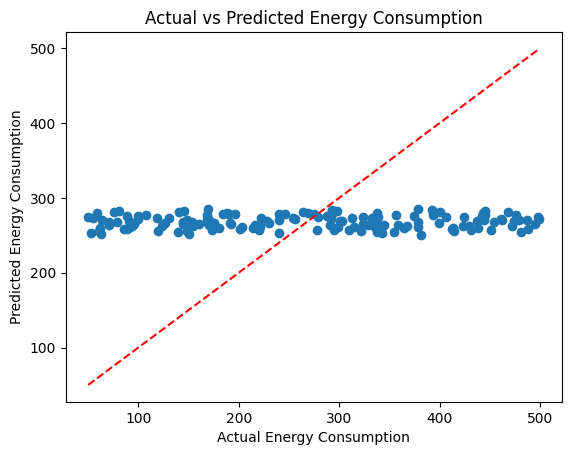

In [ ]:
import matplotlib.pyplot as plt

# Converting to Pandas DataFrame for easy plotting
pandas_df = lr_predictions.select("energy_consumption", "prediction").toPandas()

# Plotting the actual vs predicted energy consumption
plt.scatter(pandas_df["energy_consumption"], pandas_df["prediction"])
plt.plot([min(pandas_df["energy_consumption"]), max(pandas_df["energy_consumption"])], 
         [min(pandas_df["energy_consumption"]), max(pandas_df["energy_consumption"])], 
         color='red', linestyle='--')
plt.xlabel("Actual Energy Consumption")
plt.ylabel("Predicted Energy Consumption")
plt.title("Actual vs Predicted Energy Consumption")
plt.show()
